# Qualitative Evaluation for the VAE model

In [1]:
import torch
import torchgadgets as tg
import os
from pathlib import Path as P
import numpy as np
import utils
from models import ConvVAE
from tbparse import SummaryReader
from matplotlib.gridspec import GridSpec 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


from tqdm import tqdm

import matplotlib.pyplot as plt

from torchsummary import summary


## Model Information

In [2]:
exp_name = 'vae_test'
run_name = 'test_2'
checkpoint = 10

log_dir = P(os.getcwd(), 'experiments', exp_name, run_name, 'logs')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Model/Data Loading

In [3]:
# Load the config files
load_augm_config_train = utils.load_config('augm_train_preLoad') 
load_augm_config_test = utils.load_config('augm_test_preLoad')

config = utils.load_config_from_run(exp_name, run_name)
config['num_iterations'] = 500

tg.tools.set_random_seed(config['random_seed'])
##-- Load Dataset --##
# Simply load the dataset using TorchGadgets and define our dataset to apply the initial augmentations
data = tg.data.load_dataset('food101')
train_dataset = data['train_dataset']
test_dataset = data['test_dataset']
train_dataset = tg.data.ImageDataset(dataset=train_dataset, transforms=load_augm_config_train)
test_dataset = tg.data.ImageDataset(dataset=test_dataset, transforms=load_augm_config_test, train_set=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, num_workers=2)

##-- Load Model from Checkpoint --##
model = ConvVAE(input_size=(3,224,224), encoder_layers=config['encoder_layers'], decoder_layers=config['decoder_layers'], latent_dim=config['latent_dim'])
utils.load_model_from_checkpoint(exp_name, run_name, model, checkpoint)

##-- Data Augmentor --##
data_augmentor = tg.data.ImageDataAugmentor(config=config['pre_processing'])

##-- Load TensorBoard Logs --##
reader = SummaryReader(log_dir, pivot=True)
train_data = reader.scalars

train_loss = train_data.loc[:,'iteration_metrics/train_loss'].to_numpy().astype(float)
train_mse= train_data.loc[:,'iteration_metrics/mse'].to_numpy().astype(float)
train_kld = train_data.loc[:,'iteration_metrics/kld'].to_numpy().astype(float)

eval_loss = train_data.loc[:,'epoch_metrics/eval_loss'].to_numpy().astype(float)
eval_mse= np.array(train_data.loc[:,'epoch_metrics/mse'][0])
eval_kld = np.array(train_data.loc[:,'epoch_metrics/kld'][0])

train_loss = train_loss[~np.isnan(train_loss)]
eval_loss = eval_loss[~np.isnan(eval_loss)]
train_mse = train_mse[~np.isnan(train_mse)]
eval_mse = eval_mse[~np.isnan(eval_mse)]
train_kld = train_kld[~np.isnan(train_kld)]
eval_kld = eval_kld[~np.isnan(eval_kld)]


categories = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
    'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras',
    'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari',
    'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad',
    'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza',
    'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus',
    'ice_cream', 'lasagna',
    'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',
    'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings',
    'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck',
    'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich',
    'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi',
    'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese',
    'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake',
    'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'
]

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_6/experiments/vae_test/test_2/checkpoints/checkpoint_10.pth


## Model Architecture

In [4]:
print(model)
summary(model.to('cuda'), (3,224,224))

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1

## Training Progress

Text(0.5, 1.0, 'Training/Evaluation Losses')

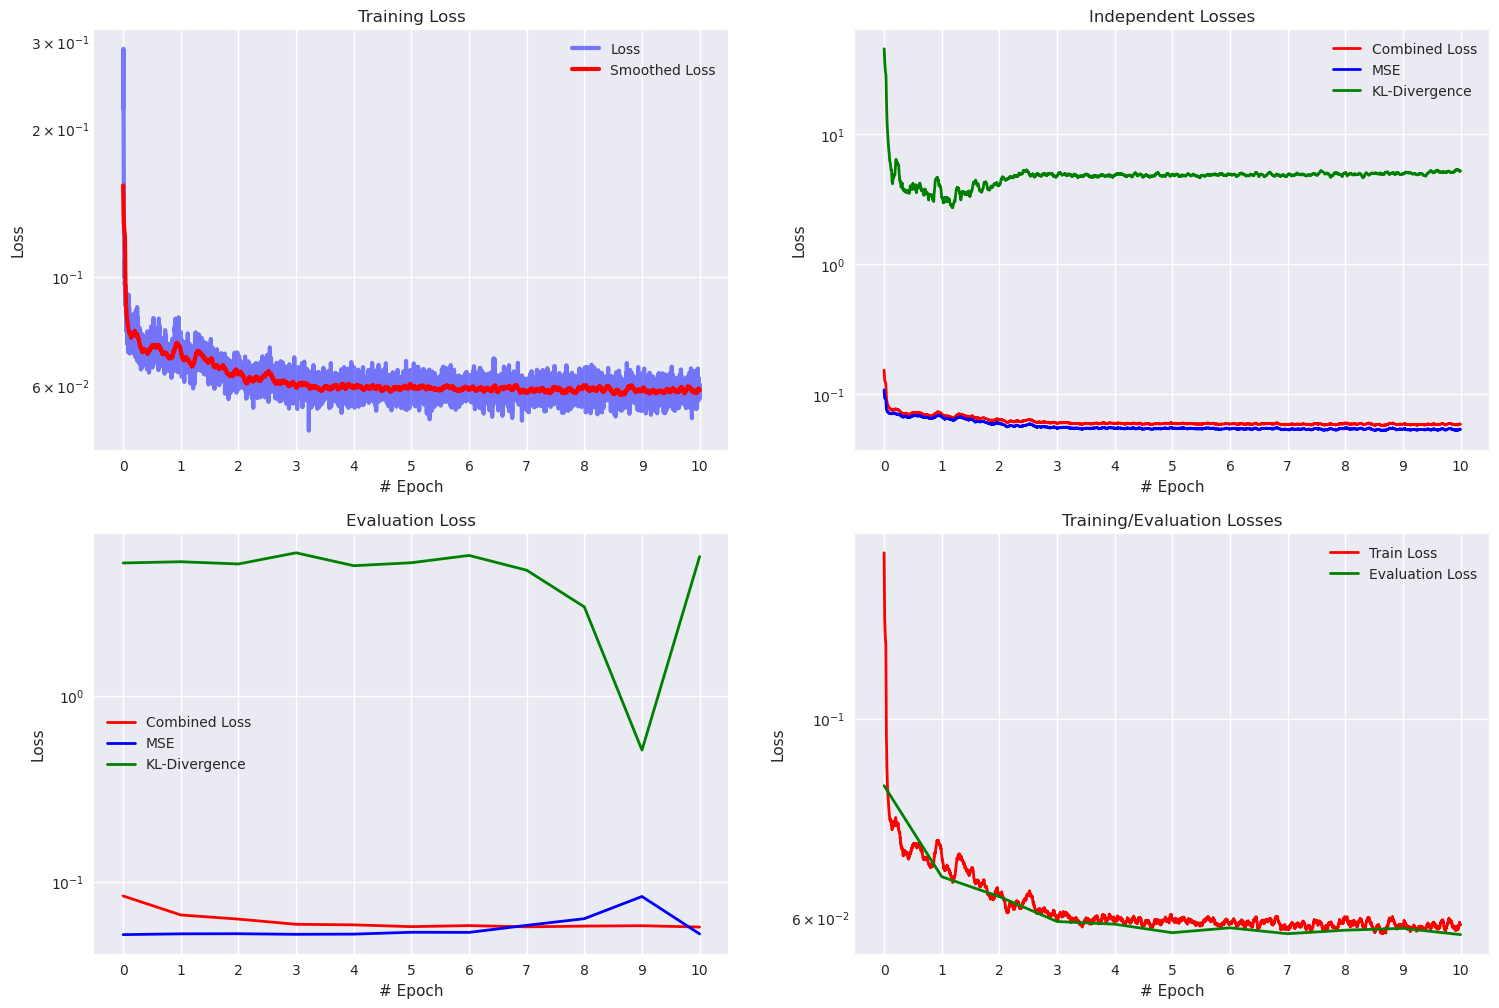

In [5]:
plt.style.use('seaborn-v0_8')

x_ticks_pos = np.arange(0, config['num_iterations']*(config['num_epochs']+1), config['num_iterations'])
x_ticks = np.arange(0,config['num_epochs']+1)

fig, ax = plt.subplots(2,2, figsize=(18,12))

smooth_loss = tg.visualization.smooth_curve(train_loss, K=31)
smooth_mse = tg.visualization.smooth_curve(train_mse, K=31)
smooth_kld = tg.visualization.smooth_curve(train_kld, K=31)

ax[0,0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0,0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0,0].set_xticks(x_ticks_pos, x_ticks)
ax[0,0].legend(loc="best")
ax[0,0].set_xlabel("# Epoch")
ax[0,0].set_ylabel("Loss")
ax[0,0].set_yscale("log")
ax[0,0].set_title("Training Loss")

ax[0,1].plot(smooth_loss, c="red", label="Combined Loss", linewidth=2, alpha=1)
ax[0,1].plot(smooth_mse, c="blue", label="MSE", linewidth=2, alpha=1)
ax[0,1].plot(smooth_kld, c="green", label="KL-Divergence", linewidth=2, alpha=1)
ax[0,1].set_xticks(x_ticks_pos, x_ticks)
ax[0,1].legend(loc="best")
ax[0,1].set_xlabel("# Epoch")
ax[0,1].set_ylabel("Loss")
ax[0,1].set_yscale("log")
ax[0,1].set_title("Independent Losses")

ax[1,0].plot(eval_loss, c="red", label="Combined Loss", linewidth=2, alpha=1)
ax[1,0].plot(eval_mse, c="blue", label="MSE", linewidth=2, alpha=1)
ax[1,0].plot(eval_kld, c="green", label="KL-Divergence", linewidth=2, alpha=1)
ax[1,0].set_xticks(x_ticks)
ax[1,0].legend(loc="best")
ax[1,0].set_xlabel("# Epoch")
ax[1,0].set_ylabel("Loss")
ax[1,0].set_yscale("log")
ax[1,0].set_title("Evaluation Loss")

ax[1,1].plot(smooth_loss, c="red", label="Train Loss", linewidth=2, alpha=1)
ax[1,1].plot(x_ticks_pos, eval_loss, c="green", label="Evaluation Loss", linewidth=2, alpha=1)
ax[1,1].set_xticks(x_ticks_pos, x_ticks)
ax[1,1].legend(loc="best")
ax[1,1].set_xlabel("# Epoch")
ax[1,1].set_ylabel("Loss")
ax[1,1].set_yscale("log")
ax[1,1].set_title("Training/Evaluation Losses")


# Evaluation Run

In [6]:
num_keep = 100

model = model.to(device)
eval_imgs, eval_output, eval_latents, eval_labels = [], [], [], []
progress_bar = tqdm(enumerate(test_loader), total=config['dataset']['test_size']//config['batch_size'])
progress_bar.set_description('Evaluation:')
with torch.no_grad():
    for i, (imgs, lbls) in progress_bar:
        imgs = imgs.to(device)
        output, (z, mu, sigma) = model(imgs)
        if i<num_keep:
            eval_imgs.append(imgs.cpu())
            eval_output.append(output.cpu())
            eval_latents.append(z.cpu())
            eval_labels.append(lbls)

model = model.to('cpu')

Evaluation::  16%|█▌        | 62/394 [00:51<04:34,  1.21it/s]


KeyboardInterrupt: 

In [ ]:
eval_imgs[0].shape

torch.Size([64, 3, 224, 224])

## Reconstruction Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


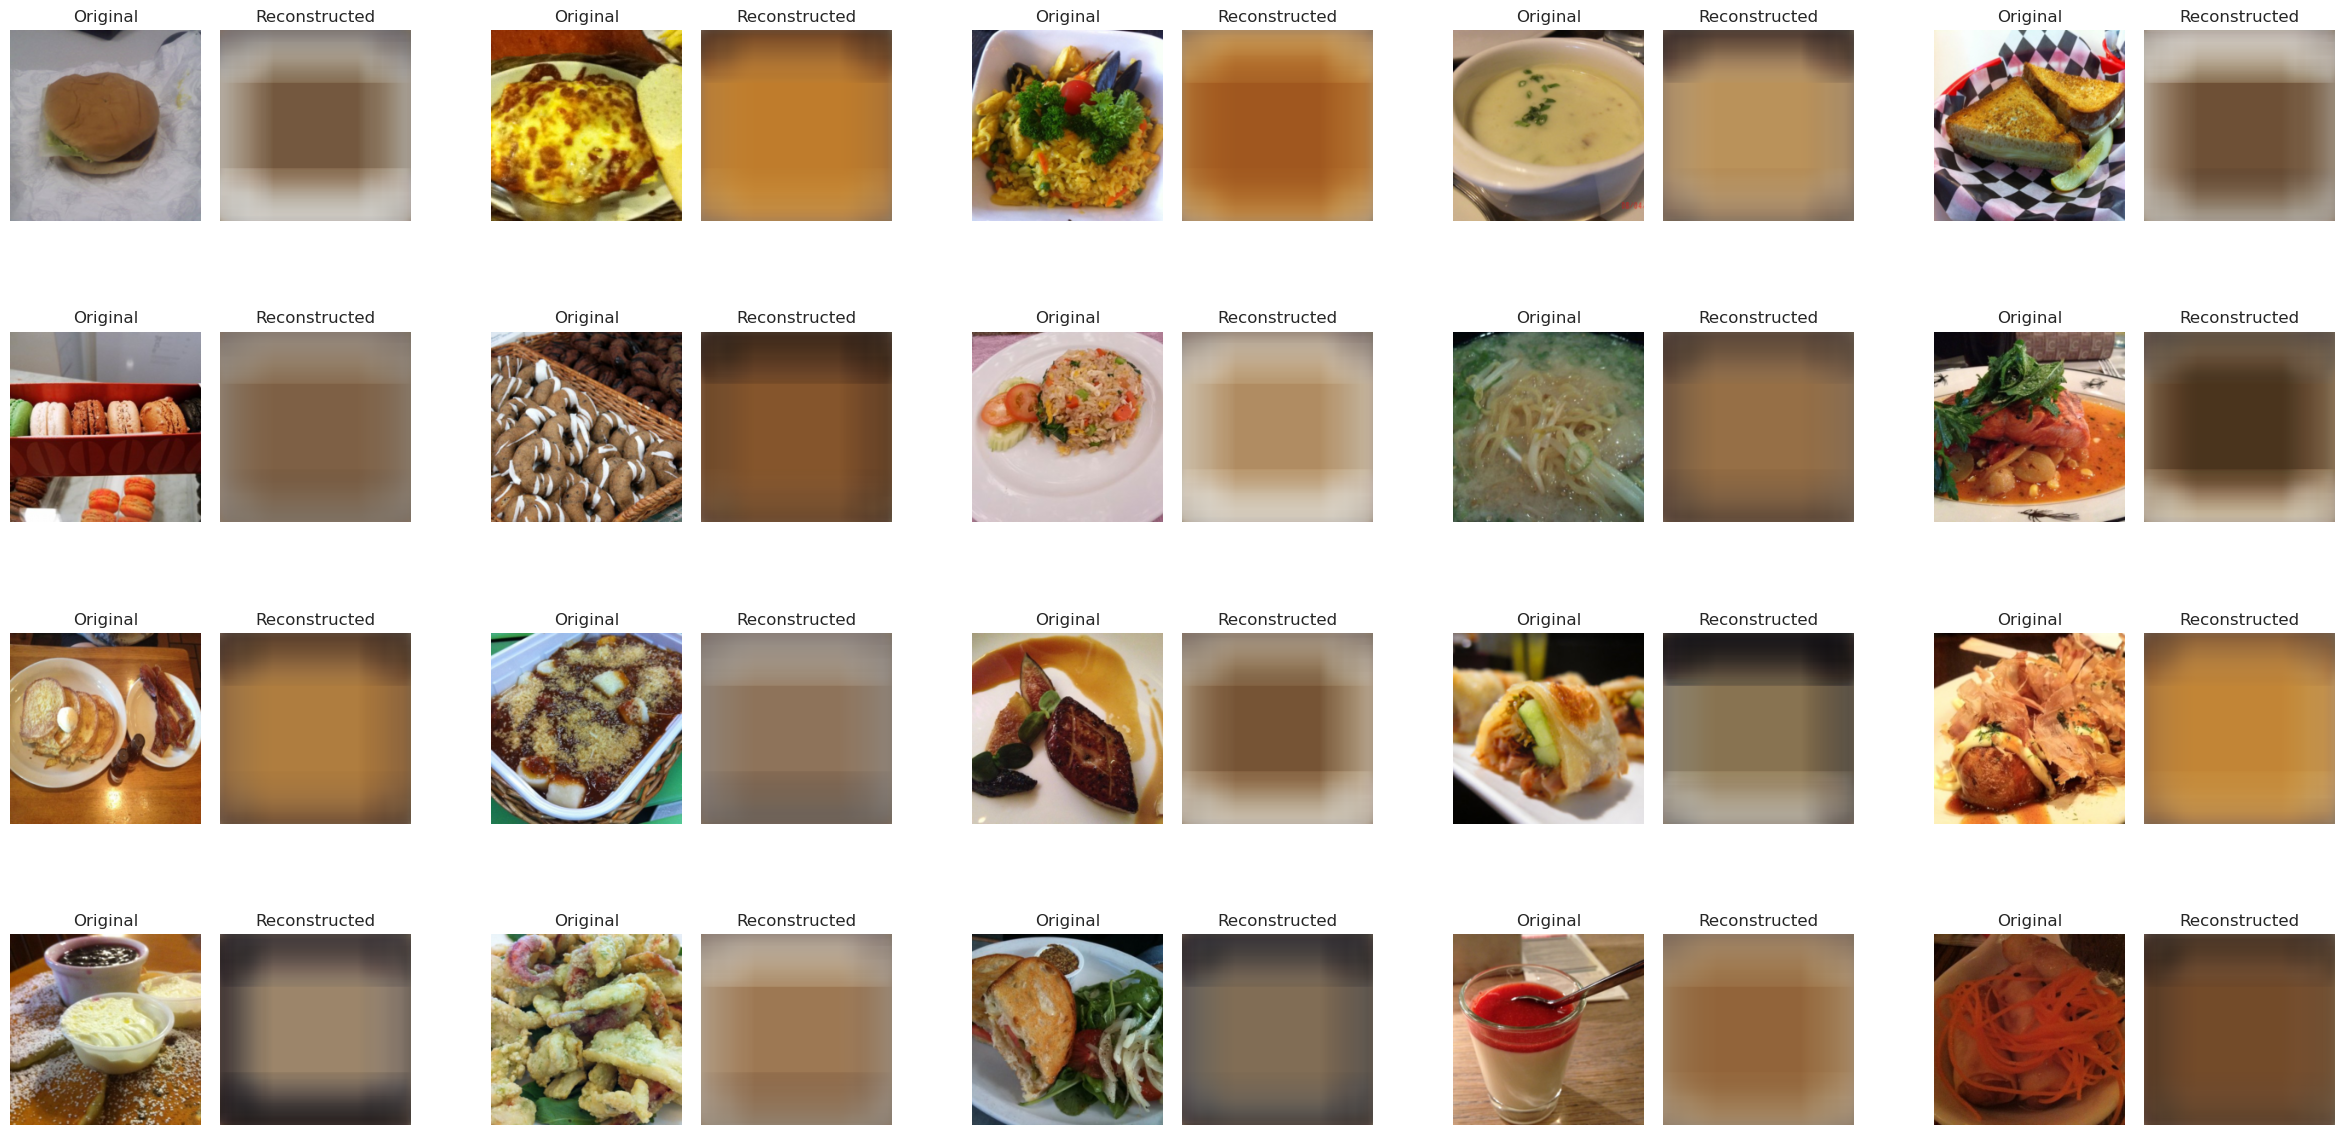

In [ ]:
img, output, label = eval_imgs[0], eval_output[0], eval_labels[0]


# Visualize images and their reconstruction
layout = (4,5)
num_imgs = layout[0]*layout[1]
fig = plt.figure(figsize=(30,15))

figure_grid = GridSpec(layout[0], layout[1], figure=fig)

img_ind = 0
for x in range(layout[0]):
    for y in range(layout[1]):
        img_plot = figure_grid[x,y].subgridspec(1,2, wspace=0.1, hspace=0.0)
        ax = fig.add_subplot(img_plot[0])
        ax.imshow(img[img_ind].permute((1,2,0)))
        ax.axis('off')
        ax.set_title('Original')
        ax = fig.add_subplot(img_plot[1])
        ax.imshow(output[img_ind].permute((1,2,0)))
        ax.axis('off')
        ax.set_title('Reconstructed')
        img_ind += 1

fig.show()

## Analysis of the Latent Space

### Visualization Latent Space

In [ ]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)])
    ax.legend(loc="best")

In [ ]:
# Parameters
num_display = 2000

eval_imgs = np.concatenate([img.view(imgs.shape[0],-1) for img in eval_imgs])
eval_latents = np.concatenate(eval_latents)
eval_labels = np.concatenate(eval_labels)

pca_imgs = PCA(n_components=2).fit_transform(eval_imgs)

# N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:num_display], eval_labels[:num_display], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(eval_latents[:num_display], eval_labels[:num_display], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

: 

: 

In [ ]:
tsne_imgs = TSNE(n_components=2).fit_transform(eval_imgs[:num_display])
tsne_latents = TSNE(n_components=2).fit_transform(eval_latents[:num_display])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:num_display], eval_labels[:num_display], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:num_display], eval_labels[:num_display], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()



### Interpolation over Latent Space

In [ ]:

@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")


In [ ]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=20)

## Garbage Collection

In [ ]:
del train_loss, eval_loss, train_mse, eval_mse, train_kld, eval_kld

del eval_output, eval_labels, eval_latents, eval_imgs